<a href="https://colab.research.google.com/github/amien1410/kaggle-projects/blob/main/Fine-Tune_LayoutLM_on_SROIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Kaggle Modules to download the dataset
!pip install kaggle

# Load Kaggle user authorization key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset, get the user and dataset name from the url "https://www.kaggle.com/datasets/shivamb/netflix-shows"
!kaggle datasets download -d onchutrng/sroie20192021

# Unzip the dataset
!unzip -q "/content/sroie20192021"

Dataset URL: https://www.kaggle.com/datasets/onchutrng/sroie20192021
License(s): unknown
 99% 1.81G/1.84G [00:18<00:00, 121MB/s]
100% 1.84G/1.84G [00:18<00:00, 109MB/s]


In [2]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher
import shutil
from PIL import Image, ImageDraw, ImageFont
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

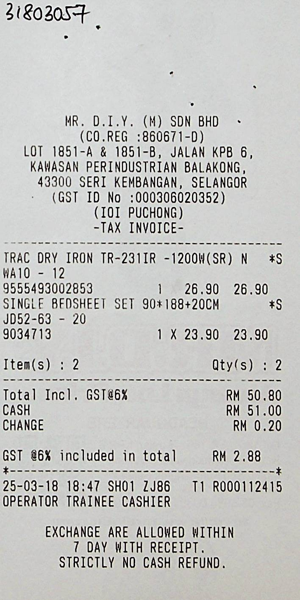

In [3]:
#@title Preparing the dataset
sroie_folder_path = Path('/content/SROIE2019-20210928T080219Z-001/SROIE2019')
example_file = Path('X51005757324.txt')
image = Image.open("/content/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task1train(626p)/X51005757324.jpg")
image = image.convert("RGB")
new_image = image.resize((300, 600))
new_image

In [4]:
#@title Reading the words and bounding boxes
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r') as f:
    for line in f.read().splitlines():
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])

  # The filename is a string so we cannot force the whole dataframe to be an integer.
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'])
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "0325updated.task1train(626p)" / example_file
print("== File content ==")
!tail -n 10 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==\n")
bbox.head(5)

== File content ==
6,928,104,928,104,955,6,955,CHANGE
550,929,665,929,665,958,550,958,RM 0.20
7,995,416,995,416,1025,7,1025,GST @6% INCLUDED IN TOTAL
502,997,616,997,616,1024,502,1024,RM 2.88
7,1063,402,1063,402,1092,7,1092,25-03-18 18:47 SHO1 ZJ86
453,1064,665,1064,665,1092,453,1092,T1 R000112415
6,1096,403,1096,403,1126,6,1126,OPERATOR TRAINEE CASHIER
107,1165,552,1165,552,1194,107,1194,EXCHANGE ARE ALLOWED WITHIN
171,1198,482,1198,482,1228,171,1228,7 DAY WITH RECEIPT.
139,1231,531,1231,531,1262,139,1262,STRICTLY NO CASH REFUND .

== Dataframe ==



,filename,x0,y0,x2,y2,line
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD
1,X51005757324,190,287,482,318,(CO. REG :860671-D)
2,X51005757324,56,321,596,354,"LOT 1851-A & 1851-B, JALAN KPB 6 ,"
3,X51005757324,70,355,579,388,"KAWASAN PERINDUSTRIAN BALAKONG ,"
4,X51005757324,88,389,583,418,"43300 SERI KEMBANGAN, SELANGOR"


In [5]:
#@title Reading the entities file
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path / "0325updated.task2train(626p)" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "MR. D.I.Y. (M) SDN BHD",
    "date": "25-03-18",
    "address": "LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR",
    "total": "50.80"
}

== Dataframe ==


,company,date,address,total
0,MR. D.I.Y. (M) SDN BHD,25-03-18,"LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERI...",50.80


In [6]:
#@title Assigning labels to words using the entities data
# Assign a label to the line by checking the similarity
# of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = 0
        for l in line_set:
          if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
            matches_count += 1

        if matches_count == len(line_set) or matches_count == len(entity_set):
            return column.upper()

    return "O"


line = bbox.loc[0,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: MR. D.I.Y. (M) SDN BHD
Assigned label: COMPANY


In [7]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if label == "ADDRESS" and (already_labeled["DATE"] or already_labeled["TOTAL"]):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(10)

,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD,COMPANY
1,X51005757324,190,287,482,318,(CO. REG :860671-D),O
2,X51005757324,56,321,596,354,"LOT 1851-A & 1851-B, JALAN KPB 6 ,",ADDRESS
3,X51005757324,70,355,579,388,"KAWASAN PERINDUSTRIAN BALAKONG ,",ADDRESS
4,X51005757324,88,389,583,418,"43300 SERI KEMBANGAN, SELANGOR",ADDRESS
5,X51005757324,124,424,532,455,(GST ID NO :000306020352),O
6,X51005757324,222,455,432,486,(IOI PUCHONG),O
7,X51005757324,220,490,434,518,-TAX INVOICE-,O
8,X51005757324,8,557,583,588,TRAC DRY IRON TR-231IR - 1200W(SR) N,O
9,X51005757324,632,559,669,586,*S,O


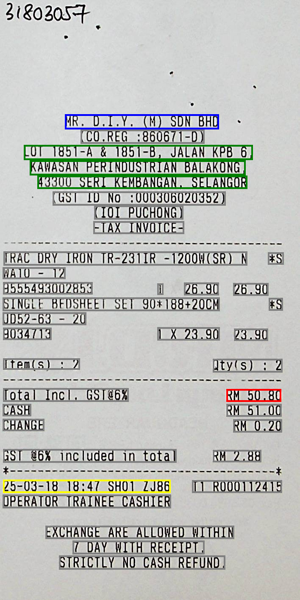

In [8]:
Color_labeled = {"TOTAL": "Red","DATE": "Yellow","ADDRESS": "Green","COMPANY": "Blue","O": "Gray"}

def Draw_BBox(image_path,_bbox_labeled: pd.DataFrame):
    actual_boxes = []
    for idx, row in _bbox_labeled.iterrows():
        x0 = row['x0']
        y0 = row['y0']
        x2 = row['x2']
        y2 = row['y2']
        label= row['label']
        color=Color_labeled[label]
        actual_box = [x0, y0, x2, y2] # we turn it into (left, top, left+width, top+height) to get the actual box
        draw = ImageDraw.Draw(image, "RGB")
        draw.rectangle(actual_box, outline=color,width=4)
        new_image = image.resize((300, 600))
    return new_image

Draw_BBox(image,bbox_labeled)

In [9]:
#@title Split words
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0


  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    # Update 'x0', 'x2', and 'line' columns separately using .at
    line_copy.at['x0'] = x0
    line_copy.at['x2'] = x2
    line_copy.at['line'] = word
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[0])
print("Original row:")
display(bbox_labeled.loc[0:0,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,202,286,MR.,COMPANY
1,X51005757324,207,253,306,286,D.I.Y.,COMPANY
2,X51005757324,311,253,360,286,(M),COMPANY
3,X51005757324,365,253,414,286,SDN,COMPANY
4,X51005757324,419,253,468,286,BHD,COMPANY


In [18]:
#@title Putting it all Together
from time import perf_counter
def dataset_creator(folder: Path, total=1000):
    bbox_folder = folder / '0325updated.task1train(626p)'
    entities_folder = folder / '0325updated.task2train(626p)'

    # Ignoring unwanted files which produced problems when I wanted to fine-tune the model with them included
    ignore = ['X51006619545.txt', 'X51006619785.txt', 'X51005663280(1).txt', 'X51005663280.txt']
    files = [file for file in bbox_folder.glob("*.txt") if file.name not in ignore]
    files = files[:total]

    data = []

    print("Reading dataset:")
    for file in tqdm(files, total=len(files)):
        bbox_file_path = file
        entities_file_path = entities_folder / file.name
        image_file_path = bbox_folder / file.with_suffix(".jpg")

        # Check if all the required files exist
        if not bbox_file_path.is_file() or not entities_file_path.is_file() or not image_file_path.is_file():
            continue

        # Read the files
        bbox = read_bbox_and_words(bbox_file_path)
        entities = read_entities(entities_file_path)
        image = Image.open(image_file_path)

        # Assign labels to lines in bbox using entities
        bbox_labeled = assign_labels(bbox, entities)
        del bbox

        # Split lines into separate tokens
        new_bbox_l = []
        for index, row in bbox_labeled.iterrows():
            new_bbox_l += split_line(row)

        # Print debug information
        print(f"Data before DataFrame creation: {new_bbox_l[:5]}")  # Print the first 5 entries for inspection

        # Create DataFrame without specifying dtype
        new_bbox_df = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)

        # Debug: Check the dtypes of the columns
        print(new_bbox_df.dtypes)

        # Identify problematic values and convert only numeric columns
        for col in new_bbox_df.columns:
            if col not in ['filename', 'label', 'line']:  # Assuming 'filename', 'label', and 'line' are non-numeric columns
                try:
                    new_bbox_df[col] = pd.to_numeric(new_bbox_df[col], errors='raise', downcast='integer')
                except ValueError as e:
                    print(f"ValueError in column '{col}': {e}")
                    print(new_bbox_df[col].head())  # Print the first few problematic values for inspection
                    continue  # Skip conversion for this column if there's an error

        del bbox_labeled

        # Do another label assignment to keep the labeling more precise
        for index, row in new_bbox_df.iterrows():
            label = row['label']

            if label != "O":
                entity = entities.iloc[0, entities.columns.get_loc(label.lower())]
                if row['line'] not in entity:
                    label = "O"
                else:
                    # Not really IOB tagging, but it gives the best results
                    label = "S-" + label

            new_bbox_df.at[index, 'label'] = label

        width, height = image.size

        data.append([new_bbox_df, width, height])

    return data

dataset = dataset_creator(sroie_folder_path)

Reading dataset:


  0%|          | 0/832 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
x2           int64
y2           int64
line        object
label       object
dtype: object
Data before DataFrame creation: [['X51006679222', 47, 150, 61, 171, 'P', 'O'], ['X51006679222', 297, 170, 339, 233, '8', 'O'], ['X51006679222', 341, 171, 365, 187, 'OZ', 'O'], ['X51006679222', 199, 240, 305, 270, 'EIGHT', 'COMPANY'], ['X51006679222', 310, 240, 416, 270, 'OUNCE', 'COMPANY']]
filename    object
x0           int64
y0           int64
x2           int64
y2           int64
line        object
label       object
dtype: object
Data before DataFrame creation: [['X51006620189', 172, 475, 207, 516, '99', 'COMPANY'], ['X51006620189', 212, 475, 300, 516, 'SPEED', 'COMPANY'], ['X51006620189', 305, 475, 376, 516, 'MART', 'COMPANY'], ['X51006620189', 381, 475, 434, 516, 'S/B', 'COMPANY'], ['X51006620189', 439, 475, 616, 516, '(519537-X)', 'COMPANY']]
filename    object
x0           int64
y0           int64
x2           int64
y2           int64
lin

In [20]:
random.Random(4).shuffle(dataset)

# Set split point to be 80% of the dataset
split_point = int(len(dataset) * 0.8)

dataset_train  = dataset[:split_point]
dataset_test = dataset[split_point:]
print(len(dataset))
print(len(dataset_train), len(dataset_test))

664
531 133
